In [1]:
import pandas as pd
import random as rnd 
import mysql.connector
from mysql.connector import Error
import plotly
import json
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pymysql
import plotly.express as px
import plotly.graph_objects as go
from sqlalchemy import create_engine
import networkx as nx
from networkx_viewer import Viewer
from functools import reduce
from scipy.spatial.distance import pdist, squareform
import igraph
from cyjupyter import Cytoscape

# Scales and Abbreviations Used for the Starter and Change Analyses 

In [2]:
info_dict = {'descriptor_domain':['abilites','work_context','interests',
                               'knowledge','skills','work_styles','work_values','gwas','job_zones'],
            'starter':['IM,LV',None,'OI',None,None,'IM','EX',None,None],
            'change':[None,'CX',None,'IM, LV','IM, LV',None,None,'IM, LV','JZ']}
df_info = pd.DataFrame(data = info_dict)
df_info

,descriptor_domain,starter,change
0,abilites,"IM,LV",None
1,work_context,None,CX
2,interests,OI,None
3,knowledge,None,"IM, LV"
4,skills,None,"IM, LV"
5,work_styles,IM,None
6,work_values,EX,None
7,gwas,None,"IM, LV"
8,job_zones,None,JZ


In [3]:
connection = mysql.connector.connect(host='localhost',
                                         database='employment',
                                         user='root',
                                         password='1234')

In [4]:
def get_data(connection, descriptor_domain,filt = False,val = None):
    '''
    Return df in the SOCs-decriptor format of a specific domain 
    descriptor_domeain:
        work context
        knowledge
        skills
        gwas
        job_zones, filter
        Abilities, filter
    
    '''
    df= pd.DataFrame(data=None)
    if descriptor_domain == 'work_context':
        df= pd.read_sql('''
            SELECT title, element_name, data_value FROM employment.work_context
            LEFT JOIN employment.content_model_reference USING (element_id) 
            LEFT JOIN employment.occupation_data USING (onetsoc_code)
            WHERE scale_id LIKE 'CX';''', con = connection)
        df = df.reset_index().pivot(index = 'title', columns = 'element_name', values = 'data_value')
    elif descriptor_domain == 'job_zones':
        if filt:
            df= pd.read_sql('''
                SELECT title,job_zone FROM employment.job_zones
                LEFT JOIN employment.occupation_data USING (onetsoc_code); ''', con = connection)
            df = df[df['job_zone'].isin(val)]
        else:
            df= pd.read_sql('''
                SELECT title,job_zone FROM employment.job_zones
                LEFT JOIN employment.occupation_data USING (onetsoc_code);''', con = connection)
    elif descriptor_domain == 'abilities':
        if filt:
#             df= pd.read_sql('''
#             SELECT title, element_name, element_id,data_value FROM employment.''' + descriptor_domain + '''
#             LEFT JOIN employment.content_model_reference USING (element_id) 
#             LEFT JOIN employment.occupation_data USING (onetsoc_code); ''', con = connection)
#             df = df[df['element_id'].contains(val)]
            df= pd.read_sql('''
            SELECT title, element_name, data_value FROM employment.''' + descriptor_domain + '''
            LEFT JOIN employment.content_model_reference USING (element_id) 
            LEFT JOIN employment.occupation_data USING (onetsoc_code)
            WHERE element_id LIKE\''''+ val +'''%\'; ''', con = connection)
            
        else:
            df= pd.read_sql('''
            SELECT title, element_name,element_id, data_value FROM employment.''' + descriptor_domain + '''
            LEFT JOIN employment.content_model_reference USING (element_id) 
            LEFT JOIN employment.occupation_data USING (onetsoc_code);''', con = connection)
        df = df.groupby(by=['title','element_name'])['data_value'].mean()
        df = df.reset_index().pivot(index = 'title', columns = 'element_name', values = 'data_value')
    elif descriptor_domain == 'work_values':
        df= pd.read_sql('''
            SELECT title, element_name, data_value FROM employment.work_values
            LEFT JOIN employment.content_model_reference USING (element_id) 
            LEFT JOIN employment.occupation_data USING (onetsoc_code)
            WHERE scale_id LIKE 'EX';''', con = connection)
        df = df.reset_index().pivot(index = 'title', columns = 'element_name', values = 'data_value')
    elif descriptor_domain == 'interests':
        df= pd.read_sql('''
            SELECT title, element_name, data_value FROM employment.interests
            LEFT JOIN employment.content_model_reference USING (element_id) 
            LEFT JOIN employment.occupation_data USING (onetsoc_code)
            WHERE scale_id LIKE 'OI';''', con = connection)
        df = df.reset_index().pivot(index = 'title', columns = 'element_name', values = 'data_value')
    elif descriptor_domain == 'work_styles':
        df= pd.read_sql('''
            SELECT title, element_name, data_value FROM employment.work_styles
            LEFT JOIN employment.content_model_reference USING (element_id) 
            LEFT JOIN employment.occupation_data USING (onetsoc_code)
            WHERE scale_id LIKE 'IM';''', con = connection)
        df = df.reset_index().pivot(index = 'title', columns = 'element_name', values = 'data_value')
    elif descriptor_domain == 'name':
        df= pd.read_sql('''
            SELECT * FROM employment.occupation_data;''', con = connection)
    else:
        df= pd.read_sql('''
            SELECT title, element_name, data_value FROM employment.''' + descriptor_domain + '''
            LEFT JOIN employment.content_model_reference USING (element_id) 
            LEFT JOIN employment.occupation_data USING (onetsoc_code);''', con = connection)
        df = df.groupby(by=['title','element_name'])['data_value'].mean()
        df = df.reset_index().pivot(index = 'title', columns = 'element_name', values = 'data_value')
    return df

In [5]:
get_data(connection,'abilities',True,'1.A.1.')

element_name,Category Flexibility,Deductive Reasoning,Flexibility of Closure,Fluency of Ideas,Inductive Reasoning,Information Ordering,Mathematical Reasoning,Memorization,Number Facility,Oral Comprehension,...,Originality,Perceptual Speed,Problem Sensitivity,Selective Attention,Spatial Orientation,Speed of Closure,Time Sharing,Visualization,Written Comprehension,Written Expression
title,,,,,,,,,,,,,,,,,,,,,
Accountants,3.500,4.000,3.060,3.000,3.815,3.750,4.000,2.625,4.065,3.935,...,3.000,2.880,3.750,3.125,0.500,2.750,2.375,2.315,4.125,3.815
Actors,2.875,2.940,2.315,3.190,2.940,2.940,0.500,3.940,0.620,4.060,...,3.565,1.940,3.120,3.060,0.500,2.185,2.815,2.560,3.690,3.130
Actuaries,3.940,4.435,3.380,3.560,4.310,4.065,4.750,2.685,4.625,4.250,...,3.310,2.940,4.130,3.500,0.500,2.815,2.440,2.690,4.310,3.875
Acupuncturists,3.310,3.875,3.375,2.815,4.065,3.250,2.000,1.500,2.380,4.065,...,2.815,2.560,3.875,2.815,0.815,2.500,2.500,2.940,3.810,3.500
Acute Care Nurses,3.250,4.000,2.940,3.000,4.000,4.000,2.815,2.880,2.630,4.120,...,3.000,3.000,4.435,3.120,0.500,2.875,3.000,2.750,4.000,3.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wind Energy Project Managers,3.250,4.190,3.060,3.250,4.000,3.440,3.310,2.620,3.060,4.125,...,3.065,2.500,3.940,2.810,0.875,2.620,2.560,3.000,4.125,3.815
Wind Turbine Service Technicians,3.060,3.685,3.250,2.880,3.315,3.380,2.250,2.750,2.125,3.750,...,2.685,3.185,3.500,2.935,2.000,2.625,2.685,3.500,3.315,2.685
"Woodworking Machine Setters, Operators, and Tenders, Except Sawing",2.940,2.940,2.940,2.000,2.815,2.940,1.940,1.940,2.190,3.440,...,2.000,3.060,3.065,3.370,1.435,2.625,2.435,3.435,2.880,1.875


In [6]:
# df_try = pd.read_sql('''
#             SELECT title, element_name, data_value FROM employment.''' + 'skills' + '''
#             LEFT JOIN employment.content_model_reference USING (element_id) 
#             LEFT JOIN employment.occupation_data USING (onetsoc_code);''', con = connection)
# df_try[df_try['title']=='Accountants'].sort_values(by =['element_name'])

# Abilities

In [7]:
df_ab = get_data(connection,'abilities')
df_ab

element_name,Arm-Hand Steadiness,Auditory Attention,Category Flexibility,Control Precision,Deductive Reasoning,Depth Perception,Dynamic Flexibility,Dynamic Strength,Explosive Strength,Extent Flexibility,...,Speed of Limb Movement,Stamina,Static Strength,Time Sharing,Trunk Strength,Visual Color Discrimination,Visualization,Wrist-Finger Speed,Written Comprehension,Written Expression
title,,,,,,,,,,,,,,,,,,,,,
Accountants,1.065,1.500,3.500,0.880,4.000,1.250,0.500,0.815,0.500,0.500,...,0.50,0.500,0.500,2.375,1.060,1.875,2.315,1.000,4.125,3.815
Actors,1.875,1.940,2.875,0.500,2.940,0.500,0.500,1.940,1.190,1.940,...,0.50,1.875,1.940,2.815,2.380,1.940,2.560,0.685,3.690,3.130
Actuaries,0.620,1.810,3.940,0.500,4.435,1.185,0.500,0.500,0.500,0.500,...,0.50,0.500,0.500,2.440,1.060,1.875,2.690,0.750,4.310,3.875
Acupuncturists,3.185,1.870,3.310,2.060,3.875,1.625,0.500,1.750,0.500,1.875,...,0.94,1.690,1.810,2.500,2.250,2.315,2.940,1.000,3.810,3.500
Acute Care Nurses,1.375,2.185,3.250,1.250,4.000,1.875,0.500,1.125,1.940,1.060,...,0.75,1.875,2.565,3.000,1.250,3.000,2.750,0.880,4.000,3.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wind Energy Project Managers,0.940,2.190,3.250,1.125,4.190,1.810,0.500,0.750,0.685,0.815,...,0.50,0.685,0.815,2.560,1.875,2.185,3.000,1.940,4.125,3.815
Wind Turbine Service Technicians,3.375,2.620,3.060,3.310,3.685,3.120,1.310,2.935,0.875,3.190,...,2.25,2.750,3.000,2.685,3.000,3.125,3.500,1.940,3.315,2.685
"Woodworking Machine Setters, Operators, and Tenders, Except Sawing",3.120,3.250,2.940,3.560,2.940,2.940,1.185,2.940,1.500,3.000,...,2.50,2.310,3.185,2.435,3.185,2.560,3.435,2.620,2.880,1.875


# Interests

In [8]:
df_in = get_data(connection,'interests')
df_in

element_name,Artistic,Conventional,Enterprising,Investigative,Realistic,Social
title,,,,,,
Accountants,1.00,7.00,4.00,3.00,1.33,1.67
Actors,6.67,1.67,4.67,1.33,2.67,3.00
Actuaries,1.67,6.00,3.33,4.33,2.00,1.00
Acupuncturists,2.33,1.67,2.00,5.00,5.33,6.00
Acute Care Nurses,2.00,1.67,2.33,5.33,4.33,7.00
...,...,...,...,...,...,...
Wind Energy Project Managers,2.33,4.67,7.00,4.33,2.33,2.00
Wind Turbine Service Technicians,1.00,4.00,2.33,2.33,6.67,1.33
"Woodworking Machine Setters, Operators, and Tenders, Except Sawing",1.67,4.67,1.33,3.67,7.00,1.00


# Work Styles

In [9]:
df_ws = get_data(connection,'work_styles')
df_ws

element_name,Achievement/Effort,Adaptability/Flexibility,Analytical Thinking,Attention to Detail,Concern for Others,Cooperation,Dependability,Independence,Initiative,Innovation,Integrity,Leadership,Persistence,Self Control,Social Orientation,Stress Tolerance
title,,,,,,,,,,,,,,,,
Accountants,3.63,3.78,4.21,4.80,3.05,4.06,4.68,3.82,3.87,2.99,4.79,2.82,4.03,3.74,3.10,3.77
Actors,4.73,4.78,3.25,4.05,4.16,5.00,4.78,3.90,4.81,4.06,3.93,3.72,4.84,4.53,4.79,4.63
Actuaries,4.44,3.81,4.81,4.75,2.59,3.97,4.38,3.44,4.16,3.22,4.69,3.56,4.19,3.34,2.28,3.81
Acupuncturists,3.65,3.81,3.95,4.42,4.64,3.99,4.44,4.40,4.13,3.79,4.68,3.93,3.92,4.47,3.95,4.06
Acute Care Nurses,4.25,4.71,4.11,4.75,4.71,4.68,4.75,3.96,4.39,3.50,4.89,4.11,4.11,4.61,4.43,4.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wind Energy Project Managers,3.97,4.08,3.79,4.25,3.30,4.07,4.07,3.60,4.13,3.47,4.15,4.09,4.28,3.77,3.39,4.08
Wind Turbine Service Technicians,3.42,3.70,4.06,4.14,3.51,3.78,4.07,3.44,3.73,3.21,3.74,3.38,3.64,3.57,3.20,3.61
"Woodworking Machine Setters, Operators, and Tenders, Except Sawing",3.28,3.71,3.48,4.40,3.10,3.53,4.21,3.68,3.32,3.44,3.61,2.74,3.53,3.49,2.46,3.35


# Work Values

In [10]:
df_wv = get_data(connection, 'work_values')
df_wv

element_name,Achievement,Independence,Recognition,Relationships,Support,Working Conditions
title,,,,,,
Accountants,5.33,5.00,4.67,5.00,5.00,4.83
Actors,5.67,4.67,4.67,6.00,2.00,4.17
Actuaries,4.67,4.67,4.33,3.67,4.33,5.00
Acupuncturists,5.00,5.00,4.00,5.00,4.00,4.50
Acute Care Nurses,5.67,4.67,4.33,6.33,5.67,5.17
...,...,...,...,...,...,...
Wind Energy Project Managers,6.00,6.00,5.67,4.33,4.00,5.50
Wind Turbine Service Technicians,4.00,3.00,3.00,3.67,4.33,3.83
"Woodworking Machine Setters, Operators, and Tenders, Except Sawing",2.33,3.33,2.33,3.00,5.67,3.00


### Work Context (CX)

In [11]:
df_wc = get_data(connection,'work_context')
# df_wc.pivot(index = 'title', columns = 'element_name', values = 'data_value')
# df_wc.iloc[0:1,0:5]
# df.iloc[[1,10,9],[1,4,5]]
df_wc

element_name,Consequence of Error,Contact With Others,Coordinate or Lead Others,"Cramped Work Space, Awkward Positions",Deal With External Customers,Deal With Physically Aggressive People,Deal With Unpleasant or Angry People,Degree of Automation,Electronic Mail,Exposed to Contaminants,...,Spend Time Standing,"Spend Time Using Your Hands to Handle, Control, or Feel Objects, Tools, or Controls",Spend Time Walking and Running,Structured versus Unstructured Work,Telephone,Time Pressure,Very Hot or Cold Temperatures,"Wear Common Protective or Safety Equipment such as Safety Shoes, Glasses, Gloves, Hearing Protection, Hard Hats, or Life Jackets","Wear Specialized Protective or Safety Equipment such as Breathing Apparatus, Safety Harness, Full Protection Suits, or Radiation Protection",Work With Work Group or Team
title,,,,,,,,,,,,,,,,,,,,,
Accountants,2.88,4.59,3.05,1.12,3.92,1.03,2.25,3.20,4.97,1.23,...,1.89,1.77,1.70,4.71,4.89,4.61,1.19,1.15,1.00,3.66
Actors,1.97,4.71,3.16,1.89,3.65,1.48,2.67,1.35,4.68,2.29,...,3.83,2.07,2.56,2.88,3.67,4.59,1.50,1.32,1.15,5.00
Actuaries,3.28,3.62,3.12,1.06,2.66,1.03,1.91,2.50,5.00,1.00,...,1.69,1.83,1.26,3.91,4.62,3.62,1.03,1.00,1.00,3.97
Acupuncturists,2.90,4.80,3.18,1.52,3.70,1.36,2.51,1.44,4.29,1.78,...,3.34,3.69,1.90,4.46,4.41,3.03,1.23,2.23,1.00,3.56
Acute Care Nurses,4.77,4.81,4.00,2.89,4.52,3.00,4.07,2.46,4.48,3.56,...,3.78,3.04,3.56,4.30,5.00,4.56,1.19,4.24,2.92,4.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wind Energy Project Managers,2.35,4.00,3.77,1.16,3.79,1.16,2.47,1.55,4.85,1.43,...,2.18,1.91,1.73,4.69,4.85,3.50,1.92,2.26,1.15,4.35
Wind Turbine Service Technicians,3.72,4.60,3.76,4.17,2.86,1.33,2.10,1.96,4.34,3.76,...,3.68,3.69,2.68,3.72,3.99,3.61,4.12,4.96,4.74,4.56
"Woodworking Machine Setters, Operators, and Tenders, Except Sawing",2.80,3.64,3.18,2.99,2.28,1.23,2.76,2.13,1.57,4.99,...,4.74,4.81,3.30,3.70,2.61,3.96,3.51,4.32,1.99,4.19


### Knowledge

In [12]:
df_knowledge = get_data(connection,'knowledge')
df_knowledge

element_name,Administration and Management,Biology,Building and Construction,Chemistry,Clerical,Communications and Media,Computers and Electronics,Customer and Personal Service,Design,Economics and Accounting,...,Philosophy and Theology,Physics,Production and Processing,Psychology,Public Safety and Security,Sales and Marketing,Sociology and Anthropology,Telecommunications,Therapy and Counseling,Transportation
title,,,,,,,,,,,,,,,,,,,,,
Accountants,3.255,0.500,0.710,0.530,4.400,2.460,3.325,3.605,0.625,4.880,...,0.595,0.535,1.140,1.290,1.085,0.960,0.640,1.215,0.615,1.120
Actors,2.395,0.560,1.355,0.520,2.150,4.375,2.160,3.030,2.205,1.425,...,2.780,0.805,1.085,3.570,1.890,3.020,3.880,1.390,2.250,1.365
Actuaries,4.015,0.815,0.815,0.610,2.420,2.195,4.140,2.840,1.655,4.720,...,0.720,0.770,1.550,2.235,1.405,2.845,1.955,0.970,1.045,1.110
Acupuncturists,2.620,3.750,1.225,2.435,2.725,2.535,2.595,4.635,1.290,2.355,...,3.405,1.465,1.540,4.695,2.250,3.210,3.210,1.220,4.305,1.190
Acute Care Nurses,2.925,3.410,0.785,2.800,2.895,2.215,2.805,4.985,1.000,1.395,...,2.990,1.895,1.480,4.910,3.000,1.700,3.340,1.735,4.250,1.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wind Energy Project Managers,4.420,1.540,4.185,1.815,3.340,2.945,3.370,3.795,3.860,3.620,...,1.395,2.730,2.760,2.005,3.070,2.790,1.765,2.385,0.990,2.900
Wind Turbine Service Technicians,2.995,1.575,3.490,2.510,3.080,2.055,4.385,2.490,3.250,1.745,...,0.660,3.570,2.275,2.325,3.275,1.130,1.260,2.985,1.345,2.935
"Woodworking Machine Setters, Operators, and Tenders, Except Sawing",1.735,0.800,2.280,1.780,0.985,0.990,1.685,1.685,2.160,0.950,...,0.685,1.420,2.925,1.020,2.355,1.260,0.575,0.650,0.845,1.680


### Skills

In [13]:
df_skills = get_data(connection,'skills')
df_skills

element_name,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,Installation,Instructing,Judgment and Decision Making,...,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing
title,,,,,,,,,,,,,,,,,,,,,
Accountants,3.185,3.940,3.185,3.000,3.815,0.50,0.500,0.500,2.815,3.500,...,1.750,3.000,3.000,3.750,3.435,2.940,1.185,3.060,0.815,3.435
Actors,2.620,3.685,2.750,2.940,3.000,0.50,0.500,0.500,2.685,2.940,...,1.000,2.185,3.750,3.940,1.810,1.810,0.815,3.000,0.500,3.130
Actuaries,3.750,4.060,4.310,3.000,4.500,0.50,0.500,0.500,3.250,4.500,...,2.060,3.000,2.880,3.940,4.190,4.250,1.375,3.310,0.500,3.690
Acupuncturists,3.310,3.685,3.125,2.940,3.815,0.50,0.875,0.500,2.685,3.500,...,2.370,3.500,3.685,3.560,2.685,2.935,1.310,2.685,1.125,3.375
Acute Care Nurses,3.815,3.940,3.750,3.815,4.000,0.50,1.440,0.500,3.690,3.875,...,3.060,3.940,4.310,4.000,3.060,3.125,1.560,3.185,1.810,3.560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wind Energy Project Managers,3.690,3.750,3.315,3.750,4.125,0.75,0.815,0.500,3.065,3.560,...,1.435,3.000,3.560,3.815,3.060,3.190,1.375,3.500,1.690,3.880
Wind Turbine Service Technicians,2.940,3.065,3.190,3.250,3.310,3.56,2.750,1.500,3.000,3.060,...,2.060,2.315,2.625,3.000,2.815,2.815,1.940,2.815,3.750,2.620
"Woodworking Machine Setters, Operators, and Tenders, Except Sawing",2.310,2.815,2.625,2.060,2.940,3.00,2.690,1.565,1.815,2.500,...,1.000,1.630,2.125,2.750,1.315,1.810,1.630,2.435,3.000,1.815


### GWAs

In [14]:
df_gwas = get_data(connection,'work_activities')
df_gwas
df_gwas

element_name,Analyzing Data or Information,Assisting and Caring for Others,Coaching and Developing Others,Communicating with Persons Outside Organization,"Communicating with Supervisors, Peers, or Subordinates",Controlling Machines and Processes,Coordinating the Work and Activities of Others,Developing Objectives and Strategies,Developing and Building Teams,Documenting/Recording Information,...,Provide Consultation and Advice to Others,Repairing and Maintaining Electronic Equipment,Repairing and Maintaining Mechanical Equipment,Resolving Conflicts and Negotiating with Others,Scheduling Work and Activities,Selling or Influencing Others,Staffing Organizational Units,Thinking Creatively,Training and Teaching Others,Updating and Using Relevant Knowledge
title,,,,,,,,,,,,,,,,,,,,,
Accountants,4.430,2.465,3.040,3.635,4.590,1.405,3.325,3.475,3.305,4.095,...,2.655,0.810,0.830,3.285,3.270,2.335,2.210,3.360,3.560,3.795
Actors,1.580,2.140,2.385,3.625,4.410,1.115,2.275,1.655,2.235,2.215,...,1.720,0.850,0.865,2.130,2.275,1.720,1.005,4.525,2.490,2.050
Actuaries,5.690,1.425,3.875,4.090,4.700,0.645,3.630,3.905,3.655,3.835,...,4.590,0.590,0.500,3.060,3.390,2.890,3.080,4.330,3.475,4.940
Acupuncturists,3.300,4.635,1.595,3.630,2.900,1.265,2.210,3.310,2.160,3.860,...,3.115,1.225,1.040,2.725,2.390,2.690,1.180,4.095,1.975,3.795
Acute Care Nurses,3.925,5.630,4.265,3.055,4.770,3.480,4.090,3.350,4.350,4.910,...,3.285,1.535,1.225,4.425,3.800,2.445,3.325,3.500,4.075,4.630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wind Energy Project Managers,4.300,2.100,2.935,5.160,4.770,1.470,4.765,3.670,4.255,3.595,...,3.830,0.965,1.640,4.320,4.325,3.770,2.410,3.915,2.910,4.495
Wind Turbine Service Technicians,3.175,2.955,3.185,2.620,3.980,4.645,3.355,2.895,2.950,3.495,...,2.820,4.805,5.055,2.365,3.280,1.795,1.640,3.485,3.465,4.290
"Woodworking Machine Setters, Operators, and Tenders, Except Sawing",2.215,1.750,1.830,1.070,3.075,4.405,2.465,1.715,2.010,2.325,...,1.655,1.900,2.620,1.535,1.685,1.045,0.860,2.555,2.145,2.700


### Job Zone (JZ)

In [15]:
df_jz = get_data(connection,'job_zones')
df_jz = df_jz[df_jz['title'] != 'Legislators']
# df_jz[df_jz.columns[1:]]
df_jz.reset_index()

,index,title,job_zone
0,0,Chief Executives,5.0
1,1,Chief Sustainability Officers,5.0
2,2,General and Operations Managers,4.0
3,4,Advertising and Promotions Managers,4.0
4,5,Marketing Managers,4.0
...,...,...,...
963,964,"Pump Operators, Except Wellhead Pumpers",2.0
964,965,Wellhead Pumpers,2.0
965,966,Refuse and Recyclable Material Collectors,2.0
966,967,Mine Shuttle Car Operators,2.0


# Combined

In [16]:
# df_name = get_data(connection,'name')
# name_dict = df_name['title'].sort_values().reset_index()['title'].to_dict()
# name_dict

In [17]:
# df = reduce(lambda x,y: pd.merge(x,y, on='title', how='outer'), [df_wc,df_knowledge,df_skills,df_gwas,df_jz])
# df_name = get_data(connection,'name')
# df[df.columns[1:]]
# name_dict = df_name['title'].to_dict()
# cols = df_wc.index
# cols
# df.index


In [18]:
def distance_table(df, jz=False):
    
#     squareform(pdist(df.iloc[:, 1:])), columns=df.title.unique(), index=df.title.unique()
    dist = []
    name_dict = {}
    if jz:
        name_dict = df['title'].sort_values().reset_index()['title'].to_dict()
        dist = pdist(df[df.columns[1:]],'euclidean')
    else:
        for i in range(len(df.index)):
            name_dict[i] = df.index[i]
        dist = pdist(df,'euclidean')
    df_dist = pd.DataFrame(squareform(dist))
#     return df_dist
    columns = list(df_dist.index)
    for i in range(len(df.index)): #convert 0 values to NaN
        df_dist.loc[i,i] = np.NaN
    mean = df_dist.mean().mean()
    std = df_dist.stack().std() 

    for col in columns: #Z-score calculated 
        df_dist[col] = (df_dist[col] - mean)/std
#     return df_dist
    return df_dist.rename(columns = name_dict, index = name_dict)

In [19]:
# df_test = pd.DataFrame(data = {'skill1':[5,5,3.5],'skill2':[2.5,3.5,4],'skill3':[3,4.5,2]})
# # df_test = pd.DataFrame(data = {'skill1':[np.NaN,5,3],'skill2':[5,np.NaN,4],'skill3':[3,4,np.NaN]})
# df_test_2 = distance_table(df_test,None)
# # df_test
# # df_test_2.stack().std()
# df_test_2.where(np.triu(np.ones(df_test_2.shape)).astype(np.bool)).stack().std()
# df_test

In [20]:
# distance_table(df_test)

In [21]:
distance_table(df_jz,True)

,Accountants,Actors,Actuaries,Acupuncturists,Acute Care Nurses,Adapted Physical Education Specialists,Adhesive Bonding Machine Operators and Tenders,"Administrative Law Judges, Adjudicators, and Hearing Officers",Administrative Services Managers,Adult Basic and Secondary Education and Literacy Teachers and Instructors,...,"Welding, Soldering, and Brazing Machine Setters, Operators, and Tenders",Wellhead Pumpers,"Wholesale and Retail Buyers, Except Farm Products",Wind Energy Engineers,Wind Energy Operations Managers,Wind Energy Project Managers,Wind Turbine Service Technicians,"Woodworking Machine Setters, Operators, and Tenders, Except Sawing",Word Processors and Typists,Zoologists and Wildlife Biologists
Accountants,NaN,-1.282951,-0.283254,-0.283254,-0.283254,-0.283254,-0.283254,0.716443,-0.283254,-1.282951,...,1.716140,1.716140,1.716140,1.716140,1.716140,1.716140,1.716140,1.716140,1.716140,1.716140
Actors,-1.282951,NaN,-0.283254,-0.283254,-0.283254,-0.283254,-0.283254,0.716443,-0.283254,-1.282951,...,1.716140,1.716140,1.716140,1.716140,1.716140,1.716140,1.716140,1.716140,1.716140,1.716140
Actuaries,-0.283254,-0.283254,NaN,-1.282951,-1.282951,-1.282951,-1.282951,-0.283254,-1.282951,-0.283254,...,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443
Acupuncturists,-0.283254,-0.283254,-1.282951,NaN,-1.282951,-1.282951,-1.282951,-0.283254,-1.282951,-0.283254,...,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443
Acute Care Nurses,-0.283254,-0.283254,-1.282951,-1.282951,NaN,-1.282951,-1.282951,-0.283254,-1.282951,-0.283254,...,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wind Energy Project Managers,1.716140,1.716140,0.716443,0.716443,0.716443,0.716443,0.716443,-0.283254,0.716443,1.716140,...,-1.282951,-1.282951,-1.282951,-1.282951,-1.282951,NaN,-1.282951,-1.282951,-1.282951,-1.282951
Wind Turbine Service Technicians,1.716140,1.716140,0.716443,0.716443,0.716443,0.716443,0.716443,-0.283254,0.716443,1.716140,...,-1.282951,-1.282951,-1.282951,-1.282951,-1.282951,-1.282951,NaN,-1.282951,-1.282951,-1.282951
"Woodworking Machine Setters, Operators, and Tenders, Except Sawing",1.716140,1.716140,0.716443,0.716443,0.716443,0.716443,0.716443,-0.283254,0.716443,1.716140,...,-1.282951,-1.282951,-1.282951,-1.282951,-1.282951,-1.282951,-1.282951,NaN,-1.282951,-1.282951
Word Processors and Typists,1.716140,1.716140,0.716443,0.716443,0.716443,0.716443,0.716443,-0.283254,0.716443,1.716140,...,-1.282951,-1.282951,-1.282951,-1.282951,-1.282951,-1.282951,-1.282951,-1.282951,NaN,-1.282951


In [22]:
# [df_wc,df_knowledge,df_skills,df_gwas,df_jz]
wc_dist = distance_table(df_wc)
knowledge_dist = distance_table(df_knowledge)
skills_dist = distance_table(df_skills)
gwas_dist = distance_table(df_gwas)
jz_dist = distance_table(df_jz,True)
wv_dist = distance_table(df_wv)
in_dist = distance_table(df_in)
ab_dist = distance_table(df_ab)
ws_dist = distance_table(df_ws)
df_concat = pd.concat([wc_dist,knowledge_dist,skills_dist,gwas_dist,jz_dist.multiply(1.3)]).groupby(level =0).mean()
df_concat

,Accountants,Actors,Actuaries,Acupuncturists,Acute Care Nurses,Adapted Physical Education Specialists,Adhesive Bonding Machine Operators and Tenders,"Administrative Law Judges, Adjudicators, and Hearing Officers",Administrative Services Managers,Adult Basic and Secondary Education and Literacy Teachers and Instructors,...,"Welding, Soldering, and Brazing Machine Setters, Operators, and Tenders",Wellhead Pumpers,"Wholesale and Retail Buyers, Except Farm Products",Wind Energy Engineers,Wind Energy Operations Managers,Wind Energy Project Managers,Wind Turbine Service Technicians,"Woodworking Machine Setters, Operators, and Tenders, Except Sawing",Word Processors and Typists,Zoologists and Wildlife Biologists
Accountants,NaN,0.018617,-1.219806,-0.274027,0.170523,-0.133953,0.680573,-0.674180,-0.910538,-0.969060,...,1.099700,1.179821,-0.767401,0.078790,0.580079,-0.064739,1.533727,1.450886,-0.344895,0.107040
Actors,0.018617,NaN,0.733936,-0.273989,0.626222,-0.131741,0.582786,0.419879,0.186207,-0.924469,...,0.910067,1.442991,0.486914,1.234423,1.466592,0.958894,1.652765,1.174747,0.335968,0.997845
Actuaries,-1.219806,0.733936,NaN,-0.191734,0.113464,-0.143654,0.854294,-0.718526,-0.760909,-0.316305,...,1.307632,1.421377,-0.562608,-0.322931,0.509470,-0.327235,1.614698,1.686400,0.349062,-0.085954
Acupuncturists,-0.274027,-0.273989,-0.191734,NaN,-1.040123,-1.150386,0.160126,-0.583606,-0.671413,-0.782857,...,0.641403,0.915820,-0.277507,0.288021,0.635441,0.055329,1.094824,0.991357,-0.066183,-0.067399
Acute Care Nurses,0.170523,0.626222,0.113464,-1.040123,NaN,-1.232064,0.197581,-0.278135,-0.828417,-0.116835,...,0.938109,0.886510,0.191040,0.349912,0.139923,0.235283,0.876042,1.380488,0.767800,-0.245655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wind Energy Project Managers,-0.064739,0.958894,-0.327235,0.055329,0.235283,-0.169265,0.880529,-0.514247,-1.027274,0.283010,...,0.263203,0.079800,-1.354638,-1.639267,-1.264017,NaN,-0.003430,0.775156,-0.089301,-1.378184
Wind Turbine Service Technicians,1.533727,1.652765,1.614698,1.094824,0.876042,0.692690,-0.360890,1.139539,0.414190,1.498054,...,-0.824858,-1.358262,0.285105,-0.166177,-1.014564,-0.003430,NaN,-0.450071,0.644096,-0.096709
"Woodworking Machine Setters, Operators, and Tenders, Except Sawing",1.450886,1.174747,1.686400,0.991357,1.380488,1.119131,-1.083437,1.227763,1.011114,1.279954,...,-1.879550,-1.042947,0.307278,0.680543,0.448008,0.775156,-0.450071,NaN,0.046408,0.706415
Word Processors and Typists,-0.344895,0.335968,0.349062,-0.066183,0.767800,0.408903,0.512793,-0.406396,-0.109516,-0.095822,...,-0.156701,0.087167,-0.969008,0.010655,0.363413,-0.089301,0.644096,0.046408,NaN,-0.062335


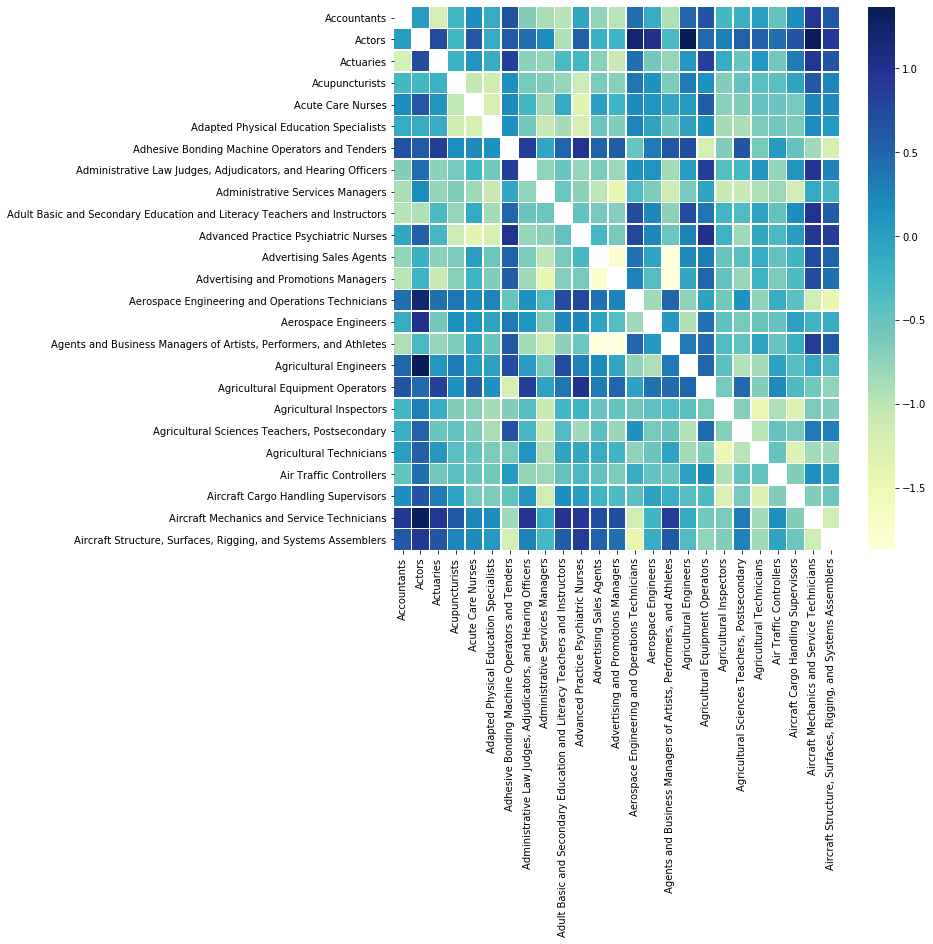

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(data = df_concat.iloc[0:25,0:25], linewidth=0.5,cmap = "YlGnBu", )
plt.show()

In [24]:
ws_dist.loc['Aircraft Structure, Surfaces, Rigging, and Systems Assemblers'].sort_values()[0:10]

Loan Interviewers and Clerks                                                      -1.766182
Bookkeeping, Accounting, and Auditing Clerks                                      -1.682774
Postal Service Clerks                                                             -1.649657
Food Science Technicians                                                          -1.636381
Executive Secretaries and Executive Administrative Assistants                     -1.515998
Secretaries and Administrative Assistants, Except Legal, Medical, and Executive   -1.491882
Payroll and Timekeeping Clerks                                                    -1.475552
Inspectors, Testers, Sorters, Samplers, and Weighers                              -1.415571
Histotechnologists and Histologic Technicians                                     -1.409465
Technical Writers                                                                 -1.402847
Name: Aircraft Structure, Surfaces, Rigging, and Systems Assemblers, dtype: floa

In [25]:
jz_dist

,Accountants,Actors,Actuaries,Acupuncturists,Acute Care Nurses,Adapted Physical Education Specialists,Adhesive Bonding Machine Operators and Tenders,"Administrative Law Judges, Adjudicators, and Hearing Officers",Administrative Services Managers,Adult Basic and Secondary Education and Literacy Teachers and Instructors,...,"Welding, Soldering, and Brazing Machine Setters, Operators, and Tenders",Wellhead Pumpers,"Wholesale and Retail Buyers, Except Farm Products",Wind Energy Engineers,Wind Energy Operations Managers,Wind Energy Project Managers,Wind Turbine Service Technicians,"Woodworking Machine Setters, Operators, and Tenders, Except Sawing",Word Processors and Typists,Zoologists and Wildlife Biologists
Accountants,NaN,-1.282951,-0.283254,-0.283254,-0.283254,-0.283254,-0.283254,0.716443,-0.283254,-1.282951,...,1.716140,1.716140,1.716140,1.716140,1.716140,1.716140,1.716140,1.716140,1.716140,1.716140
Actors,-1.282951,NaN,-0.283254,-0.283254,-0.283254,-0.283254,-0.283254,0.716443,-0.283254,-1.282951,...,1.716140,1.716140,1.716140,1.716140,1.716140,1.716140,1.716140,1.716140,1.716140,1.716140
Actuaries,-0.283254,-0.283254,NaN,-1.282951,-1.282951,-1.282951,-1.282951,-0.283254,-1.282951,-0.283254,...,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443
Acupuncturists,-0.283254,-0.283254,-1.282951,NaN,-1.282951,-1.282951,-1.282951,-0.283254,-1.282951,-0.283254,...,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443
Acute Care Nurses,-0.283254,-0.283254,-1.282951,-1.282951,NaN,-1.282951,-1.282951,-0.283254,-1.282951,-0.283254,...,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443,0.716443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wind Energy Project Managers,1.716140,1.716140,0.716443,0.716443,0.716443,0.716443,0.716443,-0.283254,0.716443,1.716140,...,-1.282951,-1.282951,-1.282951,-1.282951,-1.282951,NaN,-1.282951,-1.282951,-1.282951,-1.282951
Wind Turbine Service Technicians,1.716140,1.716140,0.716443,0.716443,0.716443,0.716443,0.716443,-0.283254,0.716443,1.716140,...,-1.282951,-1.282951,-1.282951,-1.282951,-1.282951,-1.282951,NaN,-1.282951,-1.282951,-1.282951
"Woodworking Machine Setters, Operators, and Tenders, Except Sawing",1.716140,1.716140,0.716443,0.716443,0.716443,0.716443,0.716443,-0.283254,0.716443,1.716140,...,-1.282951,-1.282951,-1.282951,-1.282951,-1.282951,-1.282951,-1.282951,NaN,-1.282951,-1.282951
Word Processors and Typists,1.716140,1.716140,0.716443,0.716443,0.716443,0.716443,0.716443,-0.283254,0.716443,1.716140,...,-1.282951,-1.282951,-1.282951,-1.282951,-1.282951,-1.282951,-1.282951,-1.282951,NaN,-1.282951


In [26]:
def filt(df,d):
    '''
    @params: df: Dataframe to filter, d: set of all relevant names
    @returns: filtered Dataframe
    '''
    return df.loc[df.index.isin(d)]

# Alternative Algorithms

## Transition out of field (jobs not so similar)

Weighting Scheme: 

Skills (3.0)

Knowledge (2.0)

GWAs


In [27]:
df_out = pd.concat([knowledge_dist.multiply(2),skills_dist.multiply(3),gwas_dist]).groupby(level =0).mean()
df_out


,Accountants,Actors,Actuaries,Acupuncturists,Acute Care Nurses,Adapted Physical Education Specialists,Adhesive Bonding Machine Operators and Tenders,"Administrative Law Judges, Adjudicators, and Hearing Officers",Administrative Services Managers,Adult Basic and Secondary Education and Literacy Teachers and Instructors,...,"Welding, Soldering, and Brazing Machine Setters, Operators, and Tenders",Wellhead Pumpers,"Wholesale and Retail Buyers, Except Farm Products",Wind Energy Engineers,Wind Energy Operations Managers,Wind Energy Project Managers,Wind Turbine Service Technicians,"Woodworking Machine Setters, Operators, and Tenders, Except Sawing",Word Processors and Typists,Zoologists and Wildlife Biologists
Accountants,NaN,0.942423,-2.638949,-0.542090,0.348451,-0.636537,1.698107,-1.966561,-1.916651,-1.414178,...,1.029282,1.851955,-2.820736,-0.030990,0.053686,-0.901016,2.216040,2.222380,-1.288157,-0.813298
Actors,0.942423,NaN,2.537272,-0.457973,1.797146,-0.210075,2.000813,0.297606,1.025987,-1.383780,...,0.917668,2.528966,0.679322,2.995816,2.911895,1.922027,3.203899,2.154341,-0.280516,1.800055
Actuaries,-2.638949,2.537272,NaN,0.521416,0.518611,0.141246,2.816396,-1.509372,-0.956759,0.008273,...,2.528067,3.219329,-1.811466,-0.512162,0.253828,-0.880059,2.975441,3.583881,1.470462,-0.775871
Acupuncturists,-0.542090,-0.457973,0.521416,NaN,-2.370137,-2.495966,1.227347,-1.381326,-0.720350,-1.450908,...,0.758618,1.754690,-0.921090,0.647829,0.732407,-0.171270,1.779257,2.034494,-0.176510,-0.906056
Acute Care Nurses,0.348451,1.797146,0.518611,-2.370137,NaN,-2.848684,1.588996,-0.774769,-1.207194,-0.396968,...,1.551892,2.004463,-0.028046,-0.223749,-0.507535,-0.365533,1.414781,3.030883,1.836894,-1.777110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wind Energy Project Managers,-0.901016,1.922027,-0.880059,-0.171270,-0.365533,-0.952643,1.394997,-0.765031,-3.032307,0.360423,...,1.124028,1.280154,-2.532563,-2.679560,-3.143132,NaN,0.088847,2.567620,1.514114,-2.167784
Wind Turbine Service Technicians,2.216040,3.203899,2.975441,1.779257,1.414781,1.164124,-2.176899,2.584567,0.375532,2.431142,...,-1.807214,-2.577266,1.265140,-0.217358,-1.536234,0.088847,NaN,-1.075553,1.912744,0.733087
"Woodworking Machine Setters, Operators, and Tenders, Except Sawing",2.222380,2.154341,3.583881,2.034494,3.030883,2.560370,-3.387105,3.190828,2.083939,2.336299,...,-4.037569,-3.001166,1.648964,2.545244,1.814134,2.567620,-1.075553,NaN,0.326502,2.767434
Word Processors and Typists,-1.288157,-0.280516,1.470462,-0.176510,1.836894,0.677951,0.322038,0.044470,0.018204,-0.821672,...,-0.552293,0.460488,-0.542534,2.219692,1.900978,1.514114,1.912744,0.326502,NaN,1.214444


In [28]:
df_out.loc['Concierges'].sort_values()[0:10]

Hotel, Motel, and Resort Desk Clerks                                              -3.980828
Travel Agents                                                                     -3.693588
Secretaries and Administrative Assistants, Except Legal, Medical, and Executive   -3.613616
Order Clerks                                                                      -3.570225
Reservation and Transportation Ticket Agents and Travel Clerks                    -3.511135
Cargo and Freight Agents                                                          -3.503204
Executive Secretaries and Executive Administrative Assistants                     -3.438953
Medical Secretaries                                                               -3.414102
Counter and Rental Clerks                                                         -3.369434
Travel Guides                                                                     -3.355858
Name: Concierges, dtype: float64

## Relevant-skills focus (Similar jobs)

Weighting Scheme: 


    
JZ (filter =True)

Abilities (filter = True)

Skills (3.0)

Knowledge (2.0)

Interests (1.0)

GWAs


In [29]:
# df_rel = pd.concat([knowledge_dist.multiply(2),skills_dist.multiply(3),gwas_dist]).groupby(level =0).mean()
df_jz_filt = get_data(connection,'job_zones',True,[2])
# df_ab_filt = get_data(connection,'abilities',True,'1.A.1.')
df_ab_filt = get_data(connection,'abilities')
# jz_dist_filt = distance_table(df_jz_filt,True)
jz_set = set(df_jz_filt['title'].unique()) #to filter out same job_zones jobs

In [30]:
abilities_filtered = filt(df_ab_filt,jz_set)
skills_filtered = filt(df_skills,jz_set)
knowledge_filtered = filt(df_knowledge,jz_set)
in_filtered = filt(df_in,jz_set)
gwas_filtered = filt(df_gwas,jz_set)

In [31]:
ab_dist_filt = distance_table(abilities_filtered) #NaN?
skills_dist_filt = distance_table(skills_filtered)
knowledge_dist_filt = distance_table(knowledge_filtered)
in_dist_filt = distance_table(in_filtered)
gwas_dist_filt = distance_table(gwas_filtered)
df_concat_filt = pd.concat([ab_dist_filt.multiply(4.0),skills_dist_filt.multiply(3.0),knowledge_dist_filt.multiply(2.0),in_dist_filt,gwas_dist_filt]).groupby(level =0).mean()

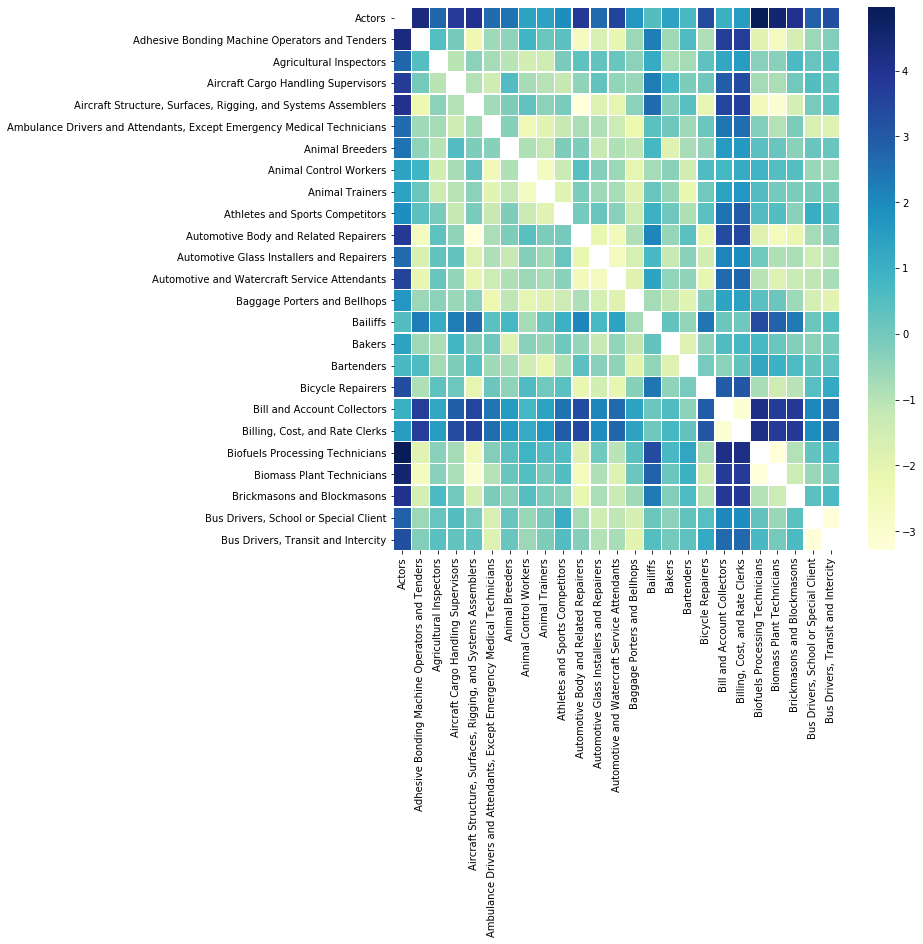

In [41]:
df_test = df_concat_filt.iloc[0:25,0:25]
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(data = df_test, linewidth=0.5,cmap = "YlGnBu", )
plt.show()

In [33]:
df_concat_filt.loc['Retail Salespersons'].sort_values()[0:20]

Demonstrators and Product Promoters                              -3.256344
Counter and Rental Clerks                                        -3.031485
Hotel, Motel, and Resort Desk Clerks                             -2.940614
Cashiers                                                         -2.623428
Bartenders                                                       -2.620159
Tellers                                                          -2.583596
Hosts and Hostesses, Restaurant, Lounge, and Coffee Shop         -2.553739
Postal Service Clerks                                            -2.423984
Reservation and Transportation Ticket Agents and Travel Clerks   -2.393816
Gaming and Sports Book Writers and Runners                       -2.361030
Slot Supervisors                                                 -2.328682
Waiters and Waitresses                                           -2.264402
First-Line Supervisors of Retail Sales Workers                   -2.248227
Order Clerks             

In [34]:
# Heat Map